In [527]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from src.dataset import Dataset
from src.distance import DistanceMatrix
from src.classifier import Classifier
from sklearn.decomposition import PCA
import matplotlib as mpl 
from src.tools import MMSeqs 
from matplotlib.gridspec import GridSpec

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [256]:
remove_fragments = lambda df : df[df.non_terminal_residue == 'none'].copy()
count_fragments = lambda df : (df.non_terminal_residue != 'none').sum()
get_smorfs = lambda df : df[df.seq.apply(len) < 100].copy()
# get_smorfs = lambda df : df[df.length < 100].copy()

In [539]:
model_name = 'model_v2'
model = Classifier.load('../models/model_v2.pkl')

annotated_results_df = pd.read_csv('../data/results/dataset_false_negative_annotated.csv', index_col=0)

mislabeled_spurious_ids = annotated_results_df[annotated_results_df.category.str.contains('error')].index
mislabeled_spurious_smorf_ids = annotated_results_df[(annotated_results_df.length < 100) & annotated_results_df.index.isin(mislabeled_spurious_ids)].index
uncertain_smorf_ids = annotated_results_df[annotated_results_df.category.str.contains('smORF') & annotated_results_df.category.str.contains('uncertain')].index
confirmed_smorf_ids = annotated_results_df[annotated_results_df.category.str.contains('smORF') & annotated_results_df.category.str.contains('confirmed')].index
conserved_smorf_ids = annotated_results_df[annotated_results_df.category.str.contains('smORF') & annotated_results_df.category.str.contains('conserved')].index
fragment_smorf_ids = annotated_results_df[(annotated_results_df.length < 100) & annotated_results_df.category.str.contains('fragment')].index

train_results_df = pd.read_csv('../data/results/dataset_train_predict.csv', index_col=0).assign(dataset='train')
test_results_df = pd.read_csv('../data/results/dataset_test_predict.csv', index_col=0).assign(dataset='test')

results_df = pd.concat([train_results_df, test_results_df])
results_df = results_df.rename(columns={f'{model_name}_output_0':'model_output_0', f'{model_name}_output_1':'model_output_1', f'{model_name}_label':'model_label'})[['model_label', 'model_output_0', 'model_output_1', 'dataset']].copy()
results_df = results_df.merge(pd.read_csv('../data/datasets/dataset.csv', index_col=0), left_index=True, right_index=True)
results_df['category'] = results_df.index.map(annotated_results_df.category).fillna('none')

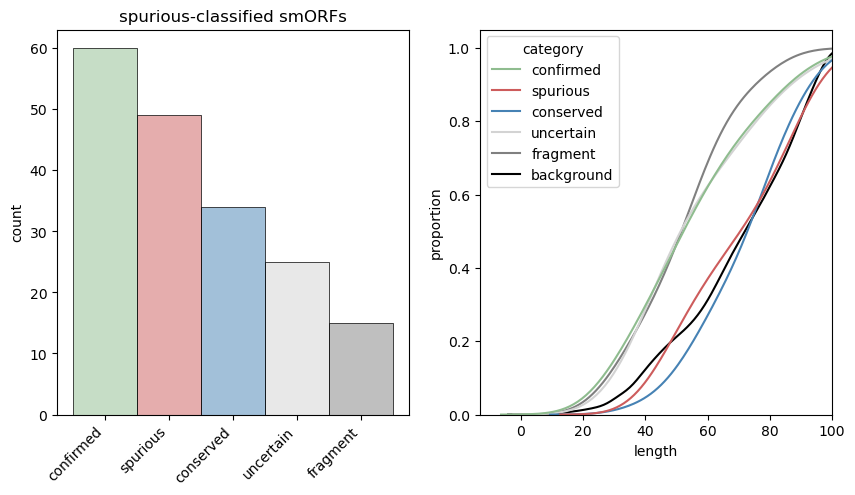

In [547]:
def figure(results_df:pd.DataFrame):

    results_df = get_smorfs(results_df)
    
    fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(10, 5))

    ax_df = pd.DataFrame(index=results_df.index)
    ax_df['length'] = results_df.seq.apply(len)

    categories = ['conserved', 'confirmed', 'uncertain', 'spurious', 'fragment']
    order = ['confirmed', 'spurious', 'conserved', 'uncertain', 'fragment', 'background']
    conditions = [results_df.category.str.contains('conserved'), results_df.category.str.contains('confirmed'), results_df.category.str.contains('uncertain'), results_df.category.str.contains('error'), results_df.category.str.contains('fragment')]
    ax_df['category'] = pd.Categorical(np.select(conditions, categories, default='background'), categories=order, ordered=True)

    palette = {'conserved':'steelblue', 'confirmed':'darkseagreen', 'uncertain':'lightgray', 'spurious':'indianred', 'fragment':'gray', 'background':'black'}
    
    sns.histplot(data=ax_df[ax_df.category != 'background'], ax=ax_a, x='category', hue='category', palette=palette, edgecolor='black', lw=0.5)
    ax_a.get_legend().remove()
    ax_a.set_ylabel('count')
    ax_a.set_xlabel('')
    ax_a.set_xticks(np.arange(5), labels=order[:-1], rotation=45, ha='right')
    ax_a.set_title('spurious-classified smORFs')

    sns.kdeplot(data=ax_df, x='length', hue='category', palette=palette, ax=ax_b, cumulative=True, common_norm=False)
    ax_b.set_xlim(xmax=100)
    ax_b.set_ylabel('proportion')

    plt.show()

figure(results_df)

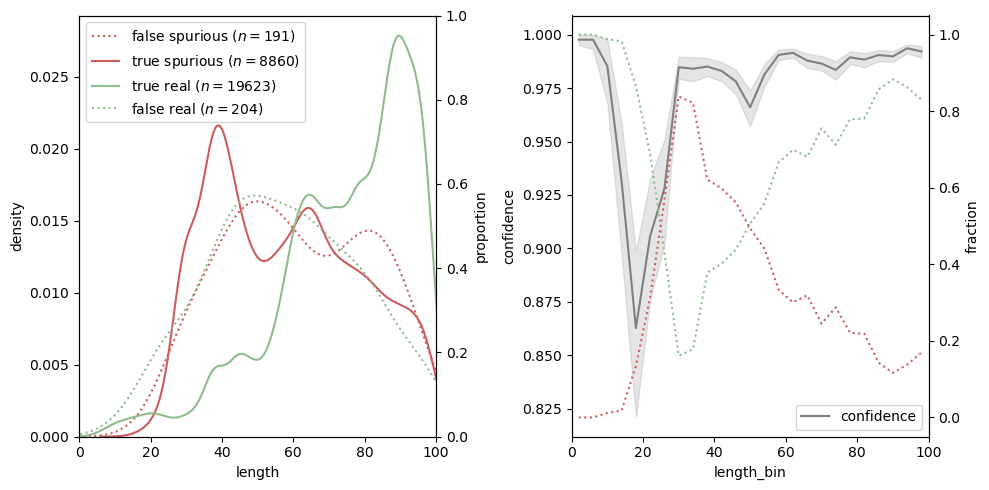

In [ ]:
# Can't just correlate sequence length and model output, as the spurious-labeled sequences have a distribution that 
# has a peak around __ amino acids; length bias would show that sequences closest in length to this peak are more likely to be 
# classified as spurious. 

def figure(results_df:pd.DataFrame, threshold:float=0.95):
    
    results_df = get_smorfs(results_df)
    results_df['model_label'] = np.where(results_df.model_output_0 > threshold, 0, 1)
    
    fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(10, 5))
    ax_a_ = ax_a.twinx()
    ax_b_ = ax_b.twinx()

    ax_df = results_df[['seq', 'label', 'model_output_0', 'model_output_1', 'model_label']].copy()
    ax_df['length'] = ax_df.seq.apply(len)
    # ax_df['confidence'] = [row.model_output_0 if (row.model_label == 0) else row.model_output_1 for row in ax_df.itertuples()]
    ax_df['confidence'] = np.abs(0.5 - results_df.model_output_1) / 0.5
    ax_df['is_correct'] = results_df.model_label == results_df.label
    ax_df['is_real'] = results_df.label == 1
    ax_df['is_spurious'] = results_df.label == 0
    
    bins = pd.cut(ax_df.length, np.arange(0, 101, 4), retbins=False)
    ax_df['length_bin'] = [bin.mid for bin in bins]

    tn_smorf_ids = list(results_df[(results_df.model_label == 0) & (results_df.label == 0)].index)
    fn_smorf_ids = list(results_df[(results_df.model_label == 0) & (results_df.label == 1)].index)
    tp_smorf_ids = list(results_df[(results_df.model_label == 1) & (results_df.label == 1)].index)
    fp_smorf_ids = list(results_df[(results_df.model_label == 1) & (results_df.label == 0)].index)

    conditions = [ax_df.index.isin(fn_smorf_ids), ax_df.index.isin(tn_smorf_ids), ax_df.index.isin(tp_smorf_ids), ax_df.index.isin(fp_smorf_ids)]
    categories = [f'false spurious ($n={len(fn_smorf_ids)}$)', f'true spurious ($n={len(tn_smorf_ids)}$)', f'true real ($n={len(tp_smorf_ids)}$)', f'false real ($n={len(fp_smorf_ids)}$)']
    ax_df['category'] = np.select(conditions, categories, default='none')
    ax_df = ax_df[ax_df.category != 'none'].copy() # TODO: Need to fix this. 

    ax_a_.set_ylabel('proportion')
    colors = ['indianred', 'indianred', 'darkseagreen', 'darkseagreen']
    styles = [':', '-', '-', ':']
    for color, style, category in zip(colors, styles, categories):
        sns.kdeplot(ax_df[ax_df.category == category], x='length', ax=ax_a, label=category, linestyle=style, color=color)
    ax_a.legend()
    # TODO: Add an ECDF plot in the background. 
    ax_a.set_ylabel('density')
    ax_a.set_xlim(xmax=100, xmin=0)

    sns.lineplot(ax_df, x='length_bin', y='is_real', ax=ax_b_, color='darkseagreen', linestyle=':', errorbar=None) # , alpha=0.5, errorbar=None)
    sns.lineplot(ax_df, x='length_bin', y='is_spurious', ax=ax_b_, color='indianred', linestyle=':', errorbar=None) # , alpha=0.5, errorbar=None)
    # sns.lineplot(ax_df[ax_df.model_label == 0], x='length_bin', y='confidence', ax=ax_b, color='indianred', label='spurious')
    # sns.lineplot(ax_df[ax_df.model_label == 1], x='length_bin', y='confidence', ax=ax_b, color='darkseagreen', label='real')
    sns.lineplot(ax_df, x='length_bin', y='confidence', ax=ax_b, color='gray', label='confidence')
    ax_b.set_xlim(xmax=100, xmin=0)
    ax_b.set_ylabel('confidence')
    ax_b_.set_ylabel('fraction')

    plt.tight_layout()
    plt.show()

figure(results_df,threshold=0.95)
# figure(results_df, mislabeled_smorf_ids=None, threshold=0.5)


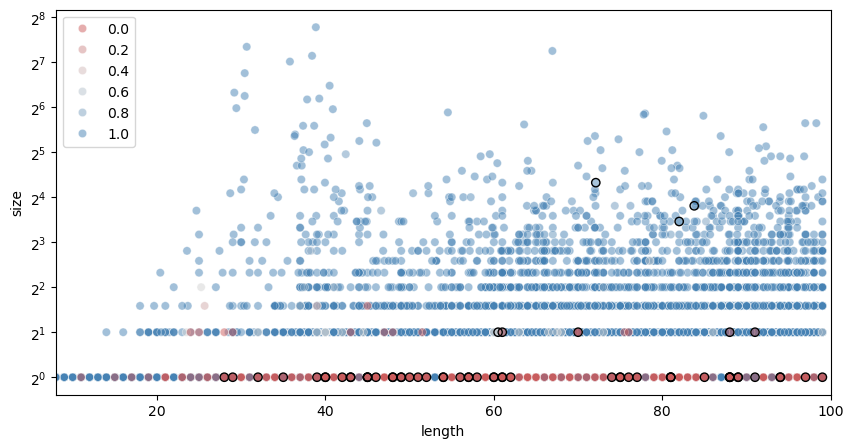

In [549]:
get_smorfs(results_df).to_csv('../data/results/dataset_smorfs.csv')

mmseqs = MMSeqs()
# align_df = mmseqs.align(query_df=get_smorfs(results_df), subject_df=results_df, query_name='smorfs', subject_name='dataset')
cluster_df = mmseqs.cluster(results_df, name='dataset', overwrite=False, sequence_identity=0.8)

results_df = get_smorfs(results_df)
results_df['model_label'] = np.where(results_df.model_output_0 > 0.95, 0, 1)
results_df['is_correct'] = results_df.model_label == results_df.label
results_df['cluster_id'] = cluster_df.cluster_id 
results_df['length'] = results_df.seq.apply(len)
results_df['mislabeled'] = results_df.index.isin(list(mislabeled_spurious_smorf_ids) + list(fragment_smorf_ids))
# results_df['uncertain'] = results_df.index.isin(uncertain_smorf_ids)

# fig, (ax_a, ax_b) = plt.subplots(figsize=(15, 10), nrows=2)
fig, ax_a = plt.subplots(figsize=(10, 5))

ax_df = pd.DataFrame(index=results_df.cluster_id.unique())
ax_df['accuracy'] = results_df.groupby('cluster_id').is_correct.mean() 
ax_df['size'] = cluster_df.groupby('cluster_id').apply(len, include_groups=False)
ax_df['length'] = results_df.groupby('cluster_id').length.mean()
ax_df['label'] = results_df.groupby('cluster_id').label.first()
ax_df['cluster_is_homogenous'] = results_df.groupby('cluster_id').label.nunique() == 1
ax_df['mislabeled_in_cluster'] = results_df.groupby('cluster_id').mislabeled.sum() > 0
ax_df = ax_df.sort_values('accuracy', ascending=False)

palette = mpl.colors.LinearSegmentedColormap.from_list('palette', ['indianred', 'lightgray', 'steelblue'])
sns.scatterplot(data=ax_df, x='length', y='size', hue='accuracy', palette=palette, ax=ax_a, alpha=0.5)
# sns.scatterplot(data=ax_df[~ax_df.cluster_is_homogenous], x='length', y='size', color='black', alpha=0.5, ax=ax_a)
# sns.scatterplot(data=ax_df[(ax_df['size'] > 10) & (ax_df.accuracy < 1)], x='length', y='size', color='none', edgecolor='black', lw=1, ax=ax_a)
sns.scatterplot(data=ax_df[ax_df.mislabeled_in_cluster], x='length', y='size', color='none', edgecolor='black', lw=1, ax=ax_a)
ax_a.set_xlim(xmin=8, xmax=100)
ax_a.set_yscale('log', base=2)

# palette = {0:'indianred', 1:'darkseagreen'}
# sns.scatterplot(data=ax_df, x='length', y='size', hue='label', palette=palette, ax=ax_b, alpha=0.5)
# sns.scatterplot(data=ax_df[ax_df.mislabeled_in_cluster], x='length', y='size', color='none', edgecolor='black', lw=1, ax=ax_b)
# ax_b.set_xlim(xmin=8, xmax=100)
# ax_b.set_yscale('log', base=2)

plt.show()


In [394]:
# print('Removing', (results_df.non_terminal_residue != 'none').sum(), 'proteins that are marked as fragments.')
# results_df = results_df[~(results_df.non_terminal_residue != 'none')].copy()
# results_df = results_df[results_df.label == 1].copy() # Remove the sequences used as spurious. 

# exclude = ['Uncharacterized protein', 'DUF3265 domain-containing protein', 'Transposase']
# exclude += list(results_df['product'].value_counts().index[results_df['product'].value_counts() < 150])
# print(f'Excluding {len(exclude)} protein families.')

# products = results_df['product'].unique()[np.argsort(results_df['product'].value_counts(sort=False).values)[::-1]]
# products = products[~np.isin(products, exclude)]

# df = list()
# for product, df_ in results_df[results_df['product'].isin(products)].groupby('product'):
#     lengths, model_outputs = df_.seq.apply(len), df_.model_output_1
#     df.append({'product':product, 'min_length':lengths.min(), 'max_length':lengths.max(), 'min_model_output':model_outputs.min(), 'max_model_output':model_outputs.max(), 'count':len(df_)})
# df = pd.DataFrame(df).set_index('product')

# df['length_diff'] = df.max_length - df.min_length
# df['model_output_diff'] = df.max_model_output - df.min_model_output
# df.sort_values('model_output_diff').iloc[:30]
# df[df.index.str.lower().str.contains('ribosomal subunit')].sort_values('min_length')

In [ ]:
# rsp_dataset_df = results_df[results_df['product'].str.contains('ribosomal subunit')].copy()
# rsp_dataset_df.to_csv('../data/results/rsp/rsp.csv')

In [11]:
# def figure(dataset_df:pd.DataFrame, products:str=['Large ribosomal subunit protein bL33', 'Large ribosomal subunit protein uL18', 'Small ribosomal subunit protein uS3', 'Small ribosomal subunit protein uS12'], scaler=None):

#     ids = dataset_df[dataset_df['product'].isin(products)].index.values 
#     print(f'figure: {len(ids)} total proteins in the specified families.')

#     dataset = Dataset.from_hdf('../data/results/rsp/rsp.h5').loc(ids)
#     matrix = DistanceMatrix.from_dataset(dataset, scaler=scaler) 
#     print(f'figure: Constructed DistanceMatrix from scaled embeddings.')
    
#     pca = PCA(n_components=2)
#     components = pca.fit_transform(matrix.numpy())
#     exp_var_0, exp_var_1 = np.round(pca.explained_variance_ratio_ * 100, 2)

#     fig, ax = plt.subplots()
#     ax_df = pd.DataFrame(components, columns=['pca_0', 'pca_1'], index=ids)
#     ax_df['length'] = lengths = dataset_df.loc[ids].seq.apply(len).values 

#     palette = mpl.colors.LinearSegmentedColormap.from_list('palette', ['steelblue', 'lightgray', 'indianred'])
#     sns.scatterplot(data=ax_df, x='pca_0', y='pca_1', ax=ax, hue='length', palette=palette)
#     ax.set_xlabel(f'pca_0 ({exp_var_0}%)')
#     ax.set_ylabel(f'pca_1 ({exp_var_1}%)')

#     linreg = LinearRegression()
#     linreg.fit(ax_df[['length']], ax_df[['pca_0', 'pca_1']])
#     r2 = r2_score(ax_df[['pca_0', 'pca_1']], linreg.predict(ax_df[['length']]), multioutput='variance_weighted')
#     # r2 = r2_score(ax_df[['pca_0', 'pca_1']], linreg.predict(ax_df[['length']]), multioutput='raw_values')
#     ax.text(0.7, 0.7, f'$R^2 = {r2:.5f}$', transform=ax.transAxes)

#     plt.show()

# figure(rsp_dataset_df)
# # figure(rsp_dataset_df, products=['Small ribosomal subunit protein uS12'])

In [9]:
# In addition to picking a particular family, probably also want to select a group of highly-homologous sequences within the family. 